## **Importing dependancies**

In [1]:
!pip install ekphrasis

     |████████████████████████████████| 80 kB 984 kB/s eta 0:00:01
     |████████████████████████████████| 64 kB 1.6 MB/s eta 0:00:01
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-py3-none-any.whl size=82843 sha256=faf825d5c8788be2148ed62c8be539f142dc419d20c6d85e5341b8c89a5609fa
  Stored in directory: /root/.cache/pip/wheels/f7/ec/0d/12659e32faf780546945d0120f2c8410eb3efb7426731da88f
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41913 sha256=4469be602993cd9bd45c88f2b5b7523262588740d8dc0d3c645f88887127e9b3
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ekphrasis ftfy


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string #string operation

#For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

#For NLP Task
import re
from ekphrasis.dicts.noslang.slangdict import slangdict
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

#For Model Building
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,SpatialDropout1D
from tensorflow.keras.optimizers import Adam

#For Wordcloud
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('../input/nlp-getting-started/train.csv')
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')

**Reading and preparation of data**

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.target.unique()

array([1, 0])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df['text'].isnull().sum()

0

## **Data Visualization**

Text(0.5, 1.0, 'Count of target feature')

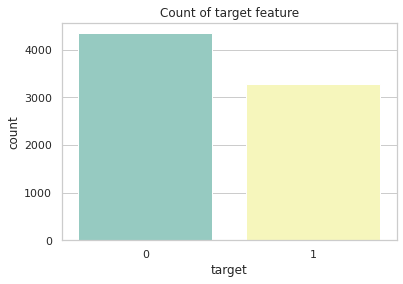

In [7]:
sns.countplot(x="target", data=df,palette="Set3")
plt.title('Count of target feature')

In [8]:
disaster_len = df[df['target']==1]['text'].str.split().map(lambda x : len(x))
non_disaster_len = df[df['target']==0]['text'].str.split().map(lambda x : len(x))
data={'Disaster_Tweets_Length':disaster_len,
     'Non_Disaster_Tweets_Length':non_disaster_len}
ndf=pd.concat(data,axis=1)

**Tweet Lengths**

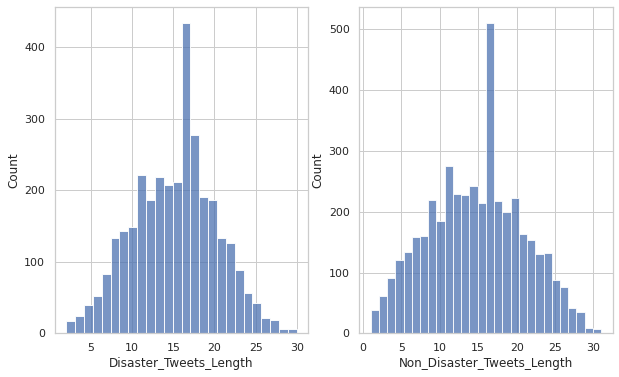

In [9]:
plt.figure(figsize=(10,6))
for i, column in enumerate(ndf.columns, 1):
    plt.subplot(1,2,i)
    sns.histplot(ndf[column])

## **Data Cleaning**

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is ", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"it's", " it is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", "  are", text)
    text = re.sub(r"\'d", "  would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"[-@#$%^&*()_'+\/<>?:;|=~,.]", "", text)
    
    return text

Slang Dictinory from ekphrasis

In [11]:
slang_dict = {}

for key, value in slangdict.items():
    slang_dict[key.lower()] = value.lower()
print('Total Slang words count:', len(slang_dict))

temp =  list(slang_dict.items())
print("\nFirst 15 Slang word and it's definitions \n")
for i in range(15):
    print(temp[i])

Total Slang words count: 5429

First 15 Slang word and it's definitions 

('*4u', 'kiss for you')
('*67', 'unknown')
('*eg*', 'evil grin')
('07734', 'hello')
('0day', 'software illegally obtained before it was released')
('0noe', 'oh no')
('0vr', 'over')
('10q', 'thank you')
('10tacle', 'tentacle')
('10x', 'thanks')
('12b', 'wannabe')
('1337', 'elite')
('133t', 'elite')
('13itch', 'bitch')
('143', 'i love you')


In [12]:
def replace_slang(txt, slang):
    new_txt = re.sub(r'\s+', ' ', txt)
    slang_conversion = []
    for tok in new_txt.split():
        if tok.lower() in slang:
            slang_conversion.append(slang[tok.lower()])
        else:
            slang_conversion.append(tok)
    slang_conversion = ' '.join(slang_conversion)
    
    return slang_conversion.strip()

## **Extra Data Exploration and Analysis with Cleaned Text**

Ekphrasis is a text processing tool, geared towards text from social networks, such as Twitter or Facebook. Ekphrasis performs tokenization, word normalization, word segmentation (for splitting hashtags) and spell correction, using word statistics from 2 big corpora (english Wikipedia, twitter - 330mil english tweets).

In [13]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


In [14]:
def preprocess(txt):
    
    #replace slang with it's defination
    text = replace_slang(txt, slang_dict)
    
    # Removing Contraction i.e I'll--> I will
    clean_txt = clean_text(text) 
    
    # Extract emojis and hashtags and segment the txt
    clean_txt = ' '.join(text_processor.pre_process_doc(clean_txt)).strip()
    for patt in [r"<elongated>", r"<repeated>"]:
        clean_txt = re.sub(patt, '', clean_txt)
    
    #replacing slangs again after extracting emojis, hashtags and segmention
    clean_txt = replace_slang(clean_txt, slang_dict)
    
    # remove punctuations
    clean_txt = re.sub(r'[%s]' % re.escape(''.join(string.punctuation)), r' ',clean_txt)
    
    # lower case
    clean_txt = clean_txt.lower()
    
    return clean_txt.strip()
    

In [15]:
train_df=df[['text','target']].copy()
train_df['Tweets'] = train_df['text'].apply(preprocess)
test_df['Tweets'] = test_df['text'].apply(preprocess)

**Cleaned Tweets**

In [16]:
for old_tweeets,new_tweets in train_df[['text','Tweets']].values[10:20]:
    print('%s\n%s\n'%(old_tweeets ,new_tweets))

Three people died from the heat wave so far
three people died from the heat wave so far

Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
haha south tampa is getting flooded hah wait a second i live in south tampa what am i going to do what am i going to do fuck flooding

#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 
raining flooding florida tampabay tampa  number  or  number  days i have lost count

#Flood in Bago Myanmar #We arrived Bago
flood in bago myanmar we arrived bago

Damage to school bus on 80 in multi car crash #BREAKING 
damage to school bus on  number  in multi car crash breaking

What's up man?
what is up man

I love fruits
i love fruits

Summer is lovely
summer is lovely

My car is so fast
my car is so fast

What a goooooooaaaaaal!!!!!!
what a goal



**Word Cloud**

In [17]:
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    color = '#ff0000'    
    return color

def green_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    color = '#00ff00'    
    return color

logo = np.array(Image.open('../input/twitter-logo/twitter-logo-clipart-black-5.png'))

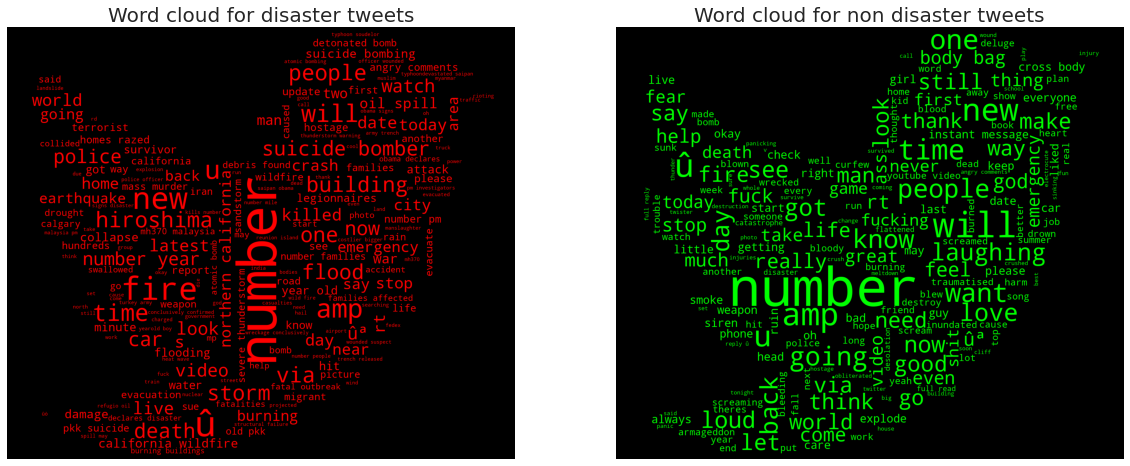

In [18]:
dis_wc = WordCloud(stopwords=STOPWORDS,  
               background_color="Black",mask=logo).generate(' '.join(train_df[train_df.target==1]['Tweets']))
image_colors = ImageColorGenerator(logo)
dis_wc.recolor(color_func=red_color_func, random_state=3)

non_dis_wc = WordCloud(stopwords=STOPWORDS,  
               background_color="Black",mask=logo).generate(' '.join(train_df[train_df.target==0]['Tweets']))
image_colors = ImageColorGenerator(logo)
non_dis_wc.recolor(color_func=green_color_func, random_state=3)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 12))

ax1.imshow(dis_wc)
ax1.set_title("Word cloud for disaster tweets", fontsize=20)
ax1.axis("off")

ax2.imshow(non_dis_wc)
ax2.set_title("Word cloud for non disaster tweets", fontsize=20)
ax2.axis("off")

fig.show()

In [19]:
embedding_dim = 16
max_length = 25
training_size = 0.8

In [20]:
sentences = train_df['Tweets']
target = train_df['target']

In [21]:
size = int(training_size * train_df.shape[0])
training_text = sentences[0:size]
testing_text = sentences[size:]
training_target = target[0:size]
testing_target = target[size:]

In [22]:
print("Shape of Training set: ",training_text.shape)
print("Shape of Testing set",testing_text.shape)

Shape of Training set:  (6090,)
Shape of Testing set (1523,)


In [23]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(training_text)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_text)
training_padded = pad_sequences(training_sequences,padding='post', maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(testing_text)
testing_padded = pad_sequences(testing_sequences,padding='post', maxlen=max_length)

vocab_size = len(tokenizer.word_index) + 1

In [24]:
training_padded = np.array(training_padded)
training_labels = np.array(training_target)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_target)

## **Modeling**

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
num_epochs = 10

history = model.fit(training_padded, training_target, epochs=num_epochs,batch_size=16, validation_data=(testing_padded, testing_target),verbose=1)

Epoch 1/10
381/381 [==============================] - 4s 6ms/step - loss: 0.6662 - accuracy: 0.5909 - val_loss: 0.5759 - val_accuracy: 0.7413
Epoch 2/10
381/381 [==============================] - 2s 6ms/step - loss: 0.4605 - accuracy: 0.8319 - val_loss: 0.4762 - val_accuracy: 0.7866
Epoch 3/10
381/381 [==============================] - 2s 5ms/step - loss: 0.2852 - accuracy: 0.9000 - val_loss: 0.4688 - val_accuracy: 0.7978
Epoch 4/10
381/381 [==============================] - 2s 5ms/step - loss: 0.1741 - accuracy: 0.9449 - val_loss: 0.4807 - val_accuracy: 0.7859
Epoch 5/10
381/381 [==============================] - 2s 5ms/step - loss: 0.1149 - accuracy: 0.9652 - val_loss: 0.5289 - val_accuracy: 0.7643
Epoch 6/10
381/381 [==============================] - 2s 7ms/step - loss: 0.0774 - accuracy: 0.9775 - val_loss: 0.5705 - val_accuracy: 0.7722
Epoch 7/10
381/381 [==============================] - 2s 6ms/step - loss: 0.0541 - accuracy: 0.9830 - val_loss: 0.6518 - val_accuracy: 0.7459
Epoch 

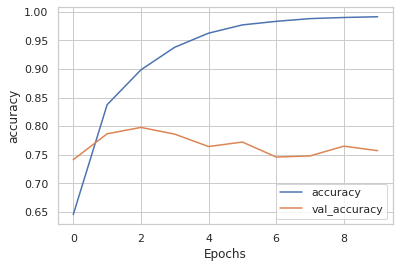

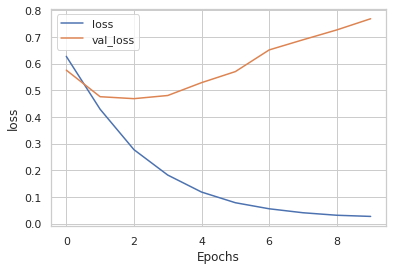

In [27]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
print("Accuracy of the model on Training Data is - " , model.evaluate(training_padded, training_target)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(testing_padded, testing_target)[1]*100)

191/191 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.9954
Accuracy of the model on Training Data is -  99.54022765159607
48/48 [==============================] - 0s 2ms/step - loss: 0.7688 - accuracy: 0.7571
Accuracy of the model on Testing Data is -  75.70584416389465
